<h1> Transfer learning using Resnet pretrained net on CIFAR10 dataset</h1>

<h3> Loading the model if saved</h3>
In this part we tend to load the model weights and the previous results of the previous runs. The only thing to remember is that if you need to restore the model just set the load parameter to True otherwise setting it to False will continue training the model and saving it finally.

In [3]:
from google.colab import drive
import pickle

load = True

drive.mount('content/')

if load:
  !cp ./content/My\ Drive/Projects/Colab/NN/HW4/part5/weights.p .
  saving_dictionary = pickle.load(open("weights.p", "rb"))


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at content/


In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds
tf.enable_eager_execution()

data, metadata = tfds.load("cifar10", with_info=True, as_supervised=True)
train_data, test_data = data['train'], data['test']


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


W0529 20:03:33.448539 139728336881536 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_datasets/core/file_format_adapter.py:264: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/1.0.2. Subsequent calls will reuse this data.
Instructions for updating:
Colocations handled automatically by placer.


W0529 20:03:41.542356 139728336881536 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:423: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


<h3>Testing the dataset</h3>
This is for testing to see if the dataset is loaded correctly. If so two images will be shown as output.

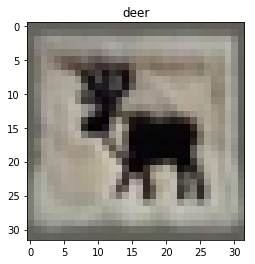

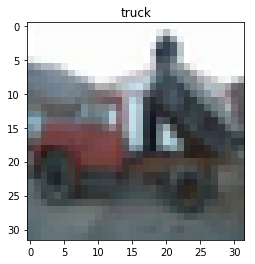

In [0]:
from matplotlib import pyplot as plt

label_names = metadata.features['label'].int2str

for image, label in train_data.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(label_names(label))
  
plt.show()


<h3> Manipulating the train and test data</h3>
In this part we tend to reform the dataset to the shape and dtype that is suitable for pretrained model and also these data will be divided into batches. 

In [2]:
def format_dataset(image, label):
  image = tf.cast(image, tf.float32)
  return image, label

train = train_data.map(format_dataset)
test = test_data.map(format_dataset)

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

for image_batch, label in train_batches.take(1):
  pass

NameError: ignored

<h3> Model definition</h3>
This part is specificallly for model definition. The model has been defined in this cell. The loss function and the optimizer has been specified here as well. 

In [0]:
keras = tf.keras
IMG_SHAPE = (32, 32, 3)

base_model = keras.applications.resnet50.ResNet50(input_shape=IMG_SHAPE, weights='imagenet', include_top=False, classes=10)

base_model.trainable = True

fine_tune_at = 130

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False
model = keras.Sequential([
    base_model,
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(10, activation='softmax'),
])

base_learning_rate = 0.1
model.compile(optimizer=keras.optimizers.SGD(lr=base_learning_rate),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 3s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


W0529 20:04:02.061450 139728336881536 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/layers/core.py:143: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 26,215,818
Trainable params: 18,724,874
Non-trainable params: 7,490,944
________________________________________________________

In [4]:
num_train = metadata.splits['train'].num_examples
num_test = metadata.splits['test'].num_examples
steps_per_epoch = round(num_train//BATCH_SIZE)
validation_steps = round(num_test // BATCH_SIZE)

_, accuracy = model.evaluate(test_batches, steps = validation_steps)
print("Initial accuracy:%.2f" % (accuracy))

NameError: ignored

In [5]:
import time
if load:
  model.set_weights(saving_dictionary['weights'])
else:
  start = time.time()
  hist = model.fit(train_batches,
         epochs=10,
         validation_data = test_batches,
         validation_steps=validation_steps,
         steps_per_epoch=int(steps_per_epoch/10),
         )
  
  
  print("The trainng took %.2f minutes" % ((time.time() - start) / 60))


NameError: ignored

<h3> Saving the model and the results </h3>
The results of the previous training phase and also the model's weights are saved as dictionary and copied to google drive. This makes it possible for the model to be restored and used later.

In [0]:
if not load:
  weights = model.get_weights()
  saving_dictionary = {'weights': weights,
                       'history':hist.history}
  pickle.dump(saving_dictionary, open("weights.p", "wb"))

  drive.mount('content/')

  !cp weights.p ./content/My\ Drive/Projects/Colab/NN/HW4/part5


<h3> Representing the results</h3>
The results of training the dataset will be plotted in this part. The outputs of this cell are two figures that each represent the loss and the accuracy of the train and test dataset respectively.

Test Accuracy: 58.65


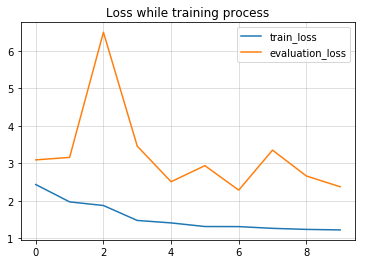

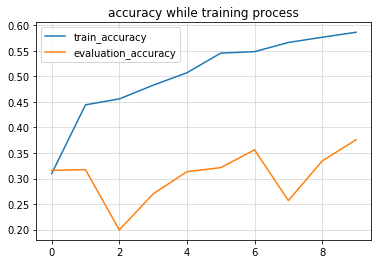

In [11]:
from matplotlib import pyplot as plt

if load:
  history = saving_dictionary['history']
else: 
  history = hist.history

print ("Test Accuracy: %.2f" % (history['acc'][-1] * 100 ))
  
plt.figure()
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(["train_loss", "evaluation_loss"])
plt.title("Loss while training process")
plt.grid(True, alpha=0.5)

plt.figure()
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.legend(["train_accuracy", "evaluation_accuracy"])
plt.title("accuracy while training process")
plt.grid(True, alpha=0.5)